# Event Detection in Fe XVIII

## Will Barnes (with many thanks to Ignacio Ugarte-Urra)

In this noteboook, we'll demonstrate how to isolate the Fe XVII emission from the 94 Å channel of SDO/AIA and detect impulsive heating events in this isolated Fe XVIII emission. This closely follows the approach of [Ugarte-Urra et al. (2018)](https://doi.org/10.1088/0004-637X/783/1/12).

In [162]:
import sys
import os

import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import dask
import dask.array as da
import distributed
from dask_jobqueue import PBSCluster
import astropy.time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.visualization import ImageNormalize,SqrtStretch,LogStretch
import sunpy
import sunpy.map
from sunpy.coordinates.frames import Helioprojective
import ndcube

import aiacube
from aiacube.prep import register_and_derotate

sys.path.append('../scripts/')
from drms_on_ames import Client

%matplotlib inline

## Query Data

We'll select the 94, 171, and 193 Å channels for AR NOAA 11459. We'll select 6 hours of data starting on 22 April 2012 00:00:00 UTC.

In [2]:
c = Client(ssh=True)

In [3]:
keys,q = c.query(
    'aia.lev1[2012-04-22T00:00:00/6h]',
    seg=['image_lev1'],
    key=['WAVELNTH'],
)
files = q[(keys['WAVELNTH']==94) |
          (keys['WAVELNTH']==171)| 
          (keys['WAVELNTH']==193)
         ].values.squeeze().tolist()  # Is there a cleaner way to do this?

../scripts/drms_on_ames.py:57: UserWarning: Warning: the ECDSA host key for 'dfe1' differs from the key for the IP address '10.150.27.122'
Offending key for IP in /etc/ssh/ssh_known_hosts:1555
Matching host key in /home4/wtbarnes/.ssh/known_hosts:3

  warnings.warn(r.stderr.decode('utf-8'))


## Spin Up Dask Cluster

Next, we'll spin up a Dask cluster on top of the PBS job scheduling system using `dask-jobqueue`.

In [15]:
with open('../jobqueue-pleiades-broadwell.yml','r') as f:
    config = yaml.load(f)['jobqueue']['pbs']

/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [2]:
cluster = distributed.LocalCluster()#PBSCluster(**config)  # configuration is offloaded to ~/.config/dask/jobqueue.yml

In [3]:
client = distributed.Client(cluster)

In [20]:
cluster.scale(30)

## Preprocess Images

Create maps, prep them, normalize to exposure time, derotate, and save them to a file to avoid doing this repeatedly.

In [21]:
maps = client.map(sunpy.map.Map, files, pure=True)

In [22]:
headers = client.map(lambda x: x.meta, maps, pure=True)

In [23]:
headers = client.gather(headers)

In [24]:
maps_94 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==94]

In [25]:
maps_171 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==171]

In [26]:
maps_193 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==193]

In [27]:
maps_94_lvl_2 = register_and_derotate(maps_94)

In [28]:
maps_171_lvl_2 = register_and_derotate(maps_171)

In [29]:
maps_193_lvl_2 = register_and_derotate(maps_193)

## Create Cropped Data Cubes

Note that, as in our other examples, this is an `NDCube` data structure backed by a Dask array.

In [30]:
cube_94 = aiacube.AIACube.from_futures(maps_94_lvl_2)

Changed DATE-OBS from '2012-04-22 00:00:02.120' to '2012-04-22T00:00:02.120''. [astropy.wcs.wcs]


In [31]:
cube_171 = aiacube.AIACube.from_futures(maps_171_lvl_2)

Changed DATE-OBS from '2012-04-22 00:00:00.340' to '2012-04-22T00:00:00.340''. [astropy.wcs.wcs]


In [32]:
cube_193 = aiacube.AIACube.from_futures(maps_193_lvl_2)

Changed DATE-OBS from '2012-04-22 00:00:07.840' to '2012-04-22T00:00:07.840''. [astropy.wcs.wcs]


Next, we want to crop these around the AR of interest.

In [33]:
fov = [302,315]*u.arcsec
center = [160,-166]*u.arcsec
lower_corner = center - fov/2
upper_corner = center + fov/2

In [34]:
cube_94_ar = cube_94.crop_by_coords(
    (0*u.s, lower_corner[1], lower_corner[0]),
    upper_corner = (6*u.h+12*u.s, upper_corner[1], upper_corner[0])
)

In [35]:
cube_94_ar[0,:,:].plot(
    cmap='sdoaia94',
    norm=ImageNormalize(vmin=10**(-0.3),vmax=10**(1.9),stretch=LogStretch())
)

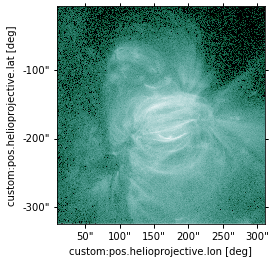

In [121]:
cube_94_ar[-3,:,:].plot(
    cmap='sdoaia94',
    norm=ImageNormalize(vmin=10**(-0.3),vmax=10**(1.9),stretch=LogStretch())
)

In [36]:
cube_171_ar = cube_171.crop_by_coords(
    (0*u.s, lower_corner[1], lower_corner[0]),
    upper_corner = (6*u.h+12*u.s, upper_corner[1], upper_corner[0])
)

In [37]:
cube_193_ar = cube_193.crop_by_coords(
    (0*u.s, lower_corner[1], lower_corner[0]),
    upper_corner = (6*u.h+12*u.s, upper_corner[1], upper_corner[0])
)

Lastly, we want to save our cropped data cubes to disk so that we don't have to go through these data prep operations again!

In [38]:
cube_94_ar.to_zarr('/nobackup/wtbarnes/fe18_event_detection/noaa_11459/aia_level_2')

In [39]:
cube_171_ar.to_zarr('/nobackup/wtbarnes/fe18_event_detection/noaa_11459/aia_level_2')

In [40]:
cube_193_ar.to_zarr('/nobackup/wtbarnes/fe18_event_detection/noaa_11459/aia_level_2')

Later, we can start from this point by simply restoring the cropped and aligned data cubes from disk.

In [4]:
cube_94_ar = aiacube.AIACube.from_zarr('/nobackup/wtbarnes/fe18_event_detection/noaa_11459/aia_level_2',
                                       94*u.angstrom)

In [5]:
cube_171_ar = aiacube.AIACube.from_zarr('/nobackup/wtbarnes/fe18_event_detection/noaa_11459/aia_level_2',
                                        171*u.angstrom)

In [6]:
cube_193_ar = aiacube.AIACube.from_zarr('/nobackup/wtbarnes/fe18_event_detection/noaa_11459/aia_level_2',
                                        193*u.angstrom)

## Isolating Fe XVIII Emission

The isolated Fe XVIII emission can be calculated by removing the "warm" component of the 94 Å channel. From Equations 1 and 2 of Ugarte-Urra et al. (2014), the warm component can be estimated as,

$$
I_{94,w} = A\sum_{i=0}^3 c_i x^i \\
x = \frac{fI_{171} + (1-f)I_{193}}{B} < I_{max}
$$

First, define the fitting paremeters

In [7]:
c_fit = [-7.19e-2, 9.75e-1, 9.79e-2, -2.81e-3]
A_fit = 0.39
B_fit = 116.32
f_fit = 0.31
I_max_fit = 27.5

Now, compute the warm component.

In [8]:
I_94_warm = 0.0
for i,cf in enumerate(c_fit):
    if i > 0:
        x = (f_fit * cube_171_ar.data + (1 - f_fit) * cube_193_ar.data) / B_fit
        x[x>=I_max_fit] = I_max_fit
    else:
        x = 1
    I_94_warm += A_fit * cf * x**i

And then the hot component

In [9]:
cube_94_ar_hot = aiacube.AIACube(
    cube_94_ar.data - I_94_warm,
    cube_94_ar.wcs,
    meta=cube_94_ar.meta)

Now let's look at the isolated hot component. We want to extract 4 different lightcurves similar to those shown in Figure 7 of Ugarte-Urra and Warren (2014)

In [183]:
points = [
    (175*u.arcsec,-195*u.arcsec),
    (190*u.arcsec,-160*u.arcsec),
    (105*u.arcsec,-150*u.arcsec),
    (200*u.arcsec,-275*u.arcsec),
]

In [184]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=cube_94_ar_hot[601,:,:].wcs.dropaxis(2))
cube_94_ar_hot[601,:,:].plot(
    axes=ax,
    cmap='Blues_r',
    norm=ImageNormalize(vmin=10**(-0.1),vmax=10**(2.5),stretch=LogStretch()),
)
ax.set_title(astropy.time.Time(cube_94_ar_hot.meta[601]['date-obs'])
             + cube_94_ar_hot.axis_world_coords('time')[601])
obs = SkyCoord(lon=cube_94_ar_hot.meta[601]['hgln_obs']*u.deg,
               lat=cube_94_ar_hot.meta[601]['hglt_obs']*u.deg,
               radius=cube_94_ar_hot.meta[601]['dsun_obs']*u.m,
               frame='heliographic_stonyhurst',
               obstime=cube_94_ar_hot.meta[601]['date-obs'])
for p in points:
    coord = SkyCoord(*p,frame='helioprojective',observer=obs)
    ax.plot_coord(coord, marker='+', color='r',markersize=20)

Let's rechunk the data cube such that subsequent slices in time will be more efficient.

In [185]:
cube_94_ar_hot_rechunk = cube_94_ar_hot.rechunk(
    cube_94_ar_hot.data.shape[:1] + (50,50)
)

Now, slice out lightcurves for the four points marked above

In [186]:
fe18_lightcurves = []
for p in points:
    _,y,x = cube_94_ar_hot_rechunk.world_to_pixel(0*u.s,*p[::-1])
    lc = cube_94_ar_hot_rechunk[:,int(y.value),int(x.value)]
    fe18_lightcurves.append(lc.data.compute())
time = lc.axis_world_coords('time')

And then overlay the four light curves on a single plot

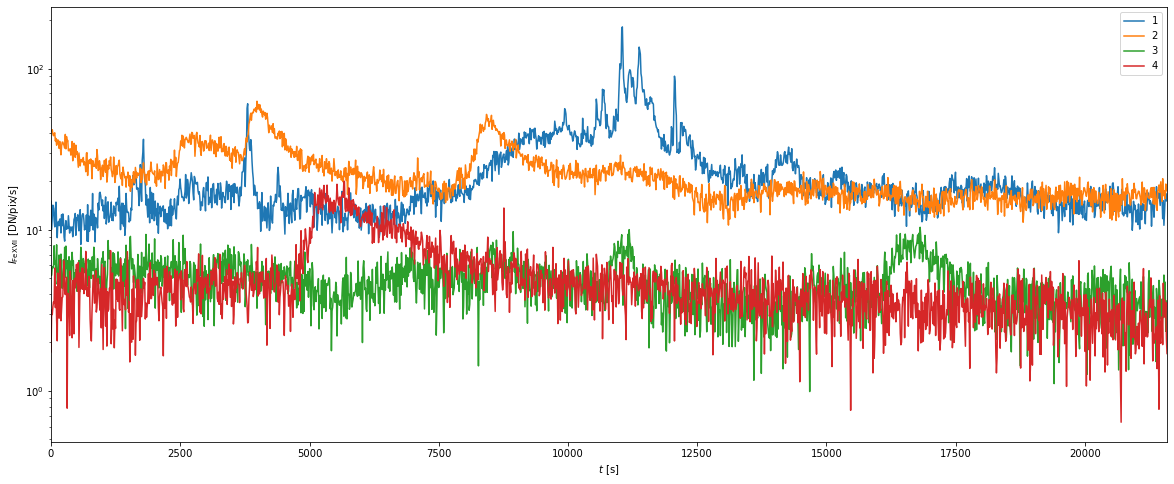

In [187]:
fig = plt.figure(figsize=(20,8))
ax = fig.gca()
for i,lc in enumerate(fe18_lightcurves):
    ax.plot(time, lc, label=i+1)
ax.legend()
ax.set_yscale('log')
ax.set_xlim(time[[0,-1]].value);
ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$I_\mathrm{Fe XVII}$ [DN/pix/s]');

## Event Detection

First, we want to test our event detection on a few 1D light curves. Once we've ensured that it is working correctly, we'll apply it to each pixel in the cube.

In [188]:
kernel = Box1DKernel(5)

In [189]:
fig,axes = plt.subplots(2,2,figsize=(15,10),sharex=True)
for i,lc in enumerate(fe18_lightcurves):
    ax = axes.flatten()[i]
    ax.plot(time, lc, color='k')
    lc_smooth = convolve(lc, kernel)
    ax.plot(time, lc_smooth, color='C1')
    ax.text(0.03, 0.95, f'{i+1}',
            transform=ax.transAxes,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=15)
ax.set_xlim(time[[0,-1]].value);
#ax.set_xlim(7500,17500)
axes[1,0].set_xlabel(r'$t$ [s]',fontsize=15)
axes[1,0].set_ylabel(r'$I_\mathrm{Fe XVII}$ [DN/pix/s]',fontsize=15);
plt.tight_layout()

In [239]:
def detect_events(data, noise_threshold=0, smoothing_window=25, time_window=10):
    """
    Count events in Fe XVIII lightcurve
    
    This is an exact translation of the IDL code and as such is not pretty.
    
    Parameters
    ----------
    data : 
        Single-pixel lightcurve as a function of time
    noise_threshold : 
    swidth :
    time_window :
    """
    tsz=data.shape[0]
    event=np.zeros((tsz,4))  #0: exist/not, 1: start, 2: peak, 3: end
    trend=np.zeros((tsz,))-2  # Default value is -2	
    threshold=np.zeros((tsz,2))

    sdata = convolve(data, Box1DKernel(smoothing_window))
    lc = sdata
    
    # Time window and spatial interval to determine threshold
    dt=time_window
    
    for k in range(dt,tsz):
        # Intensity increasing or decreasing from last point.
        if lc[k] > lc[k-1]:
            trend[k]= 1
        elif lc[k] < lc[k-1]:
            trend[k]=-1
        else:
            trend[k]= 0

        # Significance
        # If last point was not part of event
        if event[k-1,0] == 0:
            # Define threshold
            ptmin=np.argmin(lc[k-dt:k+1])
            value=np.median(sdata[k-dt+ptmin])
            svalue=np.std(sdata[k-dt+ptmin])
            threshold[k,0]=max(value+svalue, noise_threshold)
            # If larger than threshold, start event.
            if lc[k] > threshold[k,0]:
                event[k,0]=1	    #Event
                event[k,1]=k	    #Start
                event[k,2]=k	    #Peak
                event[k,3]=k	    #End
        
        
        # If last point was part of event
        if event[k-1,0] == 1:
            # If growing trend
            if trend[k] >= 0:
                # If still looking for peak, set this point as peak
                if event[k-1,2] == k-1:
                    st=int(event[k-1,1])
                    nd=k
                    event[st:nd+1,0]=1	    # Event		
                    event[st:nd+1,1]=st	    # Start
                    event[st:nd+1,2]=nd	    # Peak
                    event[st:nd+1,3]=nd	    # End
                    threshold[k,0]=max(threshold[k-1,0], noise_threshold)
                # If looking for a potential new peak, then see if above new threshold
                else:
                    threshold[k,0]=max(threshold[k-1,0], noise_threshold)
                    peak=int(event[k-1,2])	    
                    nd=k			    
                    ptmin=np.argmin(lc[peak:k+1])
                    value=np.median(sdata[peak+ptmin])
                    svalue=np.std(sdata[peak+ptmin])
                    threshold[k,1]=max(value+svalue, noise_threshold)
                    # If above threshold => new event.
                    if lc[k] > threshold[k,1]:
                        # End earlier past event if equal to this start
                        if event[k-1,3] == k:
                            pts=np.where(event[:,3]==k)
                            event[pts,3]=k-1
                        event[k,0]=1	    #Event
                        event[k,1]=k	    #Start
                        event[k,2]=k	    #Peak
                        event[k,3]=k	    #End
                        threshold[k,0]=threshold[k,1]
                    #If below threshold => still part of same event
                    else:
                        st=int(event[k-1,1])	
                        nd=k			
                        #;tmp=max(lc[st:nd],peak)
                        #;event[i,j,st:nd,2]=peak[0]+st   ;Peak
                        peak=event[k-1,2]
                        event[k,0]=1  #Event
                        event[st:nd+1,1]=st  #Start
                        event[st:nd+1,2]=peak  #Peak
                        event[st:nd+1,3]=nd  #End
            #If decreasing trend
            if trend[k] < 0:
                threshold[k,0]=max(threshold[k-1,0], noise_threshold)
                # If greater than threshold => still event
                if lc[k] > threshold[k,0]:
                    st=int(event[k-1,1])   
                    nd=k			    
                    peak=np.argmax(lc[st:nd+1])
                    event[k,0]=1                # Event
                    event[st:nd+1,1]=st         # Start
                    event[st:nd+1,2]=peak+st	# Peak
                    event[st:nd+1,3]=nd         # End
        
        # If new event (different start times), check if past event is larger than 3 datapoints.
        if event[k,1] != event[k-1,1]:
            if event[k-1,0] == 1:
                pts=np.where(event[:,1] == event[k-1,1])[0]
                npts = pts.shape[0]
                # If less than 3 datapoints
                if npts < 3:
                    # If event interrupted previous event, check if these points belong to that event
                    if event[pts[0]-1,0] == 1:
                        # If above threshold
                        if lc[pts[npts-1]] > threshold[pts[0]-1,0]:
                            st=int(event[pts[0]-1,1])	# Old start    
                            event[pts,1]=st 	# Set old start for short event
                            nd=pts[npts-1]			# New end    
                            peak=np.argmax(lc[st:nd+1])	    # New peak??
                            newpts=np.where(event[:,1] == st)
                            nnewpts = newpts[0].shape[0]
                            event[newpts,0]=1
                            event[newpts,1]=st
                            event[newpts,2]=peak + st	  
                            event[newpts,3]=nd
                        else:
                        # otherwise set to zero
                            event[pts,0]=0.
                            event[pts,1]=0.
                            event[pts,2]=0.
                            event[pts,3]=0.
                    # otherwise set to zero
                    else:
                        event[pts,0]=0.
                        event[pts,1]=0.
                        event[pts,2]=0.
                        event[pts,3]=0.
                # If more than 3 datapoints, save intensity and background
                else:
                    st=pts[0]
                    nd=pts[npts-1]
    
    # Go over all events found.
    # Extend start times and end times to start and end of 
    # increasing and decreasing trends.
    event = event.astype(int)
    start=event[:,1]
    peaks=event[:,2]
    endt=event[:,3]
    good=np.where(endt != 0)
    ngood = good[0].shape[0]
    start=start[good]
    peaks=peaks[good]
    endt=endt[good]
    start_uniq=np.unique(start)
    peaks_uniq=np.unique(peaks)
    endt_uniq=np.unique(endt)
    nevents=start_uniq.shape[0]
    
    # Look in every event.
    # Go backwards to constraint end time to start of next event
    for k in sorted(range(nevents), reverse=True):
        st=start_uniq[k]
        nd=endt_uniq[k]
        # Find previous points with increasing trend
        trendpts=np.where(trend[0:st+1] == 1)[0]
        ntrendpts = trendpts.shape[0]
        if ntrendpts > 1:
            ttrend=trend[st]
            # Set new start at the start of the trend
            while ttrend == 1:
                st=st-1
                ttrend=trend[st]
                if st == 0: ttrend=0	#Way out. Should not happen.
            # If new start, then populate new values
            if st != start_uniq[k]:
                stpts=np.where(event[:,1] == start_uniq[k])
                if stpts[0].size > 0:
                    event[stpts,1]=st
                    start_uniq[k]=st
        
        # Find following points with decreasing trend
        trendpts=np.where(trend[nd:] == -1)[0]
        ntrendpts = trendpts.shape[0]
        if ntrendpts > 1:
            ttrend=-1
            # Set new end at the end of the trend
            while ttrend == -1:
                nd=nd+1
                ttrend=trend[nd]
                if nd == tsz-1: ttrend=0	# Way out. Should not happen.
            nd=nd-1     #Go back one point from end of while-loop for last point in trend
            # Populate new values
            ndpts=np.where(event[:,3] == endt_uniq[k])
            nndpts = ndpts[0].shape[0]
            if nndpts > 0:
                # This event has to end at/before start of next event
                if k == nevents-1:
                    event[ndpts,3]=nd
                else:
                    event[ndpts,3]=min(nd, start_uniq[k+1])

        # Make sure all points in event are filled correctly
        st_event=start_uniq[k]
        nd_event=endt_uniq[k]
        if nd_event != 0:
            event[st_event:nd_event+1,0]=1
            event[st_event:nd_event+1,1]=st_event
            event[st_event:nd_event+1,2]=peaks_uniq[k]
            event[st_event:nd_event+1,3]=nd_event
    
    return event

First, estimate the noise threshold by fitting a Gaussian to the noise

In [247]:
def estimate_noise_threshold(data, bins=None, xlim=None,plot=False):
    hist,bins = np.histogram(data.flatten(),bins=bins)
    i_max = np.argmax(hist)
    bin_centers = (bins[:-1] + bins[1:])/2
    i_noise = np.where(bin_centers <= bin_centers[i_max+1])
    y = hist[i_noise]
    x = bin_centers[i_noise]
    g_init = Gaussian1D(amplitude=y.max(), mean=x[np.argmax(y)], stddev=np.diff(x)[0])
    
    fit_g = LevMarLSQFitter()
    g = fit_g(g_init, x, y)
    
    if plot:
        plt.plot(bin_centers,hist,marker='o',ls='')
        x_model = np.linspace(bin_centers.min(),
                              bin_centers.max(),
                              1000)
        plt.plot(x_model,g(x_model))
        if xlim is not None:
            plt.xlim(xlim)
    
    return g.mean + g.stddev*5.

28.638166302512882
27.386214886940376
9.768544618785164
9.14945675050458


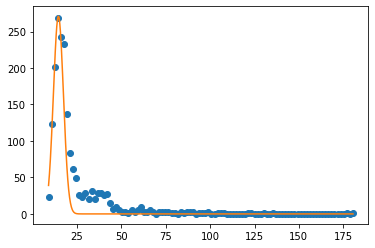

In [248]:
for lc in fe18_lightcurves:
    plt.figure()
    noise_threshold = estimate_noise_threshold(lc,bins=100,plot=True)
    print(noise_threshold)

Then, run the event detection

In [249]:
smoothing_window = 10
time_window = 10
noise_threshold = estimate_noise_threshold(fe18_lightcurves[0],bins=100,plot=False)
fe18_events = detect_events(
    fe18_lightcurves[0],
    smoothing_window=smoothing_window,
    noise_threshold=noise_threshold,
    time_window=time_window
)

Find the boundaries of the events in terms of the time index.

In [250]:
i_start = np.where(np.diff(fe18_events[:,0]) == 1)[0] + 1
i_end = np.where(np.diff(fe18_events[:,0]) == -1)[0]

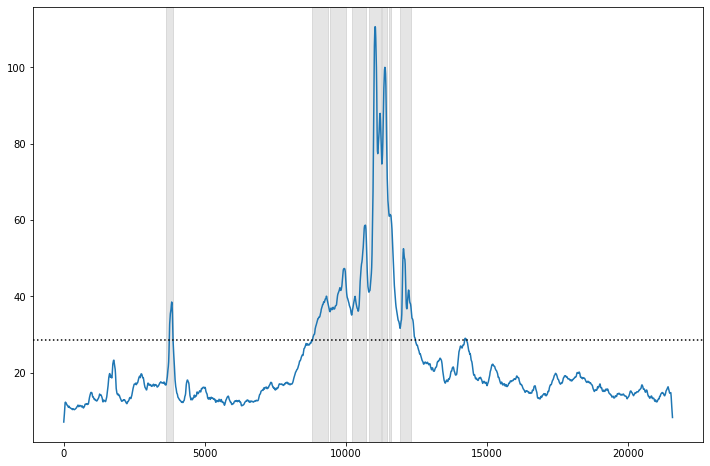

In [251]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
#plt.plot(time,fe18_events[:,0])
lc_smooth = convolve(fe18_lightcurves[0], Box1DKernel(smoothing_window))
ax.plot(time, lc_smooth)
for i_s,i_e in zip(i_start,i_end):
    ax.axvspan(time[i_s].value, time[i_e].value,color='k',alpha=0.1)
ax.axhline(y=noise_threshold, ls=':', color='k')

Now, do this for all four of the lightcurves we extracted from our datacube.

In [252]:
smoothing_window = 10
time_window = 10

In [253]:
fig,axes = plt.subplots(2,2,figsize=(15,10),sharex=True)
for i,lc in enumerate(fe18_lightcurves):
    ax = axes.flatten()[i]
    # Plot smoothed lightcurve
    lc_smooth = convolve(lc, Box1DKernel(smoothing_window))
    ax.plot(time, lc_smooth, color='C0')
    ax.text(0.03, 0.95, f'{i+1}',
            transform=ax.transAxes,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=15)
    # Estimate noise
    noise_threshold = estimate_noise_threshold(lc, bins=100, plot=False)
    print(f'Noise threshold: {noise_threshold}')
    # Run event detection
    fe18_events = detect_events(lc,
                                smoothing_window=smoothing_window,
                                noise_threshold=noise_threshold,
                                time_window=time_window)
    # Find event boundaries
    i_start = np.where(np.diff(fe18_events[:,0]) == 1)[0] + 1
    i_end = np.where(np.diff(fe18_events[:,0]) == -1)[0]
    # Plot event intervals
    for i_s,i_e in zip(i_start,i_end):
        ax.axvspan(time[i_s].value, time[i_e].value,color='k',alpha=0.1)
ax.set_xlim(time[[0,-1]].value);
#ax.set_xlim(7500,17500)
axes[1,0].set_xlabel(r'$t$ [s]',fontsize=15)
axes[1,0].set_ylabel(r'$I_\mathrm{Fe XVII}$ [DN/pix/s]',fontsize=15);
plt.tight_layout()

Noise threshold: 28.638166302512882
Noise threshold: 27.386214886940376
Noise threshold: 9.768544618785164
Noise threshold: 9.14945675050458
